# Import Required Libraries
Import the necessary libraries, including torch, torchvision, and matplotlib.

In [1]:
# Import Required Libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Download MNIST-C Dataset
Download the MNIST-C dataset from the official source or a specified URL.

In [1]:
# Download MNIST-C Dataset
import os
import urllib.request
import zipfile

# Define the URL for the MNIST-C dataset
url = 'https://zenodo.org/records/3239543/files/mnist_c.zip?download=1'

# Define the directory to save the dataset
dataset_dir = '/cis/home/xhan56/code/wtr/data'

# Create the directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Define the path to save the zip file
zip_path = os.path.join(dataset_dir, 'mnist_c.zip')

# Download the dataset
urllib.request.urlretrieve(url, zip_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

# Remove the tar file after extraction
os.remove(zip_path)

# Print a message indicating completion
print("MNIST-C dataset downloaded and extracted successfully.")

MNIST-C dataset downloaded and extracted successfully.


# Load Dataset
Use torchvision to load the MNIST-C dataset into a DataLoader.

In [4]:
from torch.utils.data import Dataset
import numpy as np

class NpyDataset(Dataset):
    """
    A custom Dataset that loads .npy image data and corresponding labels.
    """
    def __init__(self, images_path, labels_path, transform=None):
        """
        Args:
            images_path (str): Path to the .npy file containing image data.
            labels_path (str): Path to the .npy file containing labels.
            transform (callable, optional): Optional transform to be applied
                on each image.
        """
        # Load .npy arrays
        self.images = np.load(images_path)     # shape typically (N, H, W) or (N, H, W, C)
        self.labels = np.load(labels_path)     # shape (N,)

        # (Optional) Convert data to float32 if needed, or keep as is
        # self.images = self.images.astype(np.float32)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # If images are grayscale, you might need to add a channel dimension.
        # For example, if `img.shape` is (28, 28), do this:
        # img = np.expand_dims(img, axis=0)  # Now it's (1, 28, 28)

        # Convert numpy array to torch Tensor
        # img = torch.from_numpy(img)

        if self.transform:
            # If the transform expects a PIL image, you may need 
            # to convert the numpy/torch image to PIL. Alternatively, 
            # you can use transforms that work directly on tensors.
            img = self.transform(img)

        return img, label

In [16]:
# Load Dataset
from torch.utils.data import random_split, DataLoader
import os

def load_mnist_c(corruption_type='fog'):
    # Define the path to the MNIST-C dataset
    mnist_c_path = os.path.join('/cis/home/xhan56/code/wtr/data/mnist_c', corruption_type)

    # Define a transform to convert the images to tensors
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load the dataset using ImageFolder
    mnist_c_train = NpyDataset(os.path.join(mnist_c_path, 'train_images.npy'), 
                            os.path.join(mnist_c_path, 'train_labels.npy'), transform=transform)
    mnist_c_test = NpyDataset(os.path.join(mnist_c_path, 'test_images.npy'), 
                            os.path.join(mnist_c_path, 'test_labels.npy'), transform=transform)
    print('test dataset shape:', mnist_c_test.images.shape)
    # Create a DataLoader for the dataset
    train_loader_c = DataLoader(mnist_c_train, batch_size=64, shuffle=True)
    test_loader_c = DataLoader(mnist_c_test, batch_size=64, shuffle=True)

    return train_loader_c, test_loader_c

# Visualize Sample Images
Use matplotlib to visualize a few sample images from the dataset.

test dataset shape: (10000, 28, 28, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.8280098].


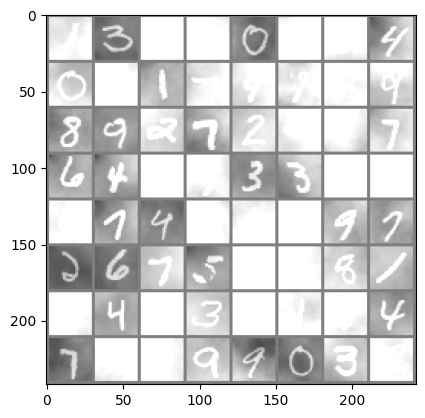

1 3 2 4 0 7 3 4


In [17]:
# Visualize Sample Images
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

train_loader, _ = load_mnist_c()
# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{labels[j]}' for j in range(8)))

In [12]:
def load_mnist(batch_size=64, normalize=True):
    """
    Load the MNIST dataset with optional normalization.

    Args:
        batch_size (int): Number of samples per batch in the DataLoader.
        normalize (bool): Whether to apply standard MNIST normalization.

    Returns:
        train_loader (DataLoader): DataLoader for the training set.
        test_loader (DataLoader): DataLoader for the test set.
    """

    # Transformations: convert to tensor and optionally normalize
    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))  # Common MNIST mean/std
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])

    # Load train & test sets
    full_train_dataset = torchvision.datasets.MNIST(
        root='/cis/home/xhan56/code/wtr/data',       # Directory to store the MNIST data
        train=True,
        transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='/cis/home/xhan56/code/wtr/data',
        train=False,
        transform=transform
    )
    train_dataset, val_dataset = random_split(full_train_dataset, [50000, 10000])
    print('test dataset shape:', test_dataset.data.shape)
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader

In [13]:
train_loader, val_loader, test_loader = load_mnist(batch_size=64, normalize=True)

# Iterate through one batch to see shapes:
images, labels = next(iter(train_loader))
print("Batch of images shape:", images.shape)  # (64, 1, 28, 28)
print("Batch of labels shape:", labels.shape)  # (64,)

test dataset shape: torch.Size([10000, 28, 28])
Batch of images shape: torch.Size([64, 1, 28, 28])
Batch of labels shape: torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


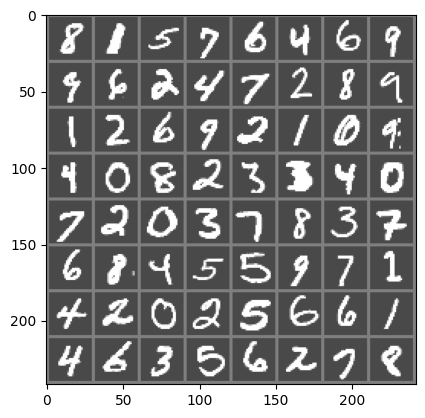

In [18]:
# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [21]:
import torch.nn as nn

class MLP(nn.Module):
    """
    A simple 3-layer MLP for MNIST classification.
    Input: (N, 1, 28, 28)
    Output: (N, 10) for 10 classes (digits 0..9)
    """
    def __init__(self, input_size=784, hidden_size=256, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (N, 1, 28, 28)
        # Flatten to (N, 784)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [22]:
def train_one_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Compute accuracy
        _, predicted = outputs.max(dim=1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, device, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(dim=1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [28]:
import torch.optim as optim

lr = 1e-3
epochs = 10
batch_size = 64
train_clean = True
corruption_type = 'fog'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_size=784, hidden_size=256, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader, test_loader = load_mnist(batch_size)
train_loader_c, test_loader_c = load_mnist_c(corruption_type=corruption_type)

if train_clean:
    print("Training on clean MNIST dataset.")
else:
    print(f"Training on {corruption_type} MNIST dataset.")

best_clean_acc = 0.0

for epoch in range(epochs):
    # Train on whichever dataset is chosen
    if train_clean:
        train_loss, train_acc = train_one_epoch(model, device, train_loader, optimizer, criterion)
    else:
        train_loss, train_acc = train_one_epoch(model, device, train_loader_c, optimizer, criterion)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")

    # Evaluate on both clean and corrupted to see performance
    clean_loss, clean_acc = evaluate(model, device, test_loader, criterion)
    print(f"   Clean Test Loss: {clean_loss:.4f}, Clean Acc: {clean_acc*100:.2f}%")

    corrupt_loss, corrupt_acc = evaluate(model, device, test_loader_c, criterion)
    print(f"   Corrupted Test Loss: {corrupt_loss:.4f}, Corrupted Acc: {corrupt_acc*100:.2f}%")

    # Save checkpoint if clean accuracy improves
    if clean_acc > best_clean_acc:
        best_clean_acc = clean_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Checkpoint saved for best model with clean accuracy: {:.2f}%".format(best_clean_acc * 100))

Training on clean MNIST dataset.
Epoch [1/10] - Train Loss: 0.2194, Train Acc: 93.37%
   Clean Test Loss: 0.1017, Clean Acc: 96.80%
   Corrupted Test Loss: 2.1847, Corrupted Acc: 33.52%
Checkpoint saved for best model with clean accuracy: 96.80%
Epoch [2/10] - Train Loss: 0.0923, Train Acc: 97.10%
   Clean Test Loss: 0.1012, Clean Acc: 96.72%
   Corrupted Test Loss: 2.3044, Corrupted Acc: 37.24%
Epoch [3/10] - Train Loss: 0.0638, Train Acc: 98.01%
   Clean Test Loss: 0.0865, Clean Acc: 97.34%
   Corrupted Test Loss: 5.7396, Corrupted Acc: 22.81%
Checkpoint saved for best model with clean accuracy: 97.34%
Epoch [4/10] - Train Loss: 0.0508, Train Acc: 98.33%
   Clean Test Loss: 0.0783, Clean Acc: 97.63%
   Corrupted Test Loss: 3.9364, Corrupted Acc: 27.95%
Checkpoint saved for best model with clean accuracy: 97.63%
Epoch [5/10] - Train Loss: 0.0424, Train Acc: 98.64%
   Clean Test Loss: 0.0731, Clean Acc: 97.82%
   Corrupted Test Loss: 5.4367, Corrupted Acc: 23.23%
Checkpoint saved for b

In [11]:
import math
# math.sqrt(2025)
math.pow(46, 2)

2116.0